- tensorflow 1.13.1
- keras 2.2.4
- pandas
- numpy 1.17.2
- pandas
- matplotlib
- sklearn
- seaborn
- 已有文件夹：
`logcurves`(原始测井数据),`输入csv`,`整合后csv`,`输出图片`,`log&h5`(存储的模型)

# 导入模块

In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import keras.backend as K
import random
import datetime

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from sklearn.model_selection import GroupKFold, KFold
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,TensorBoard
from sklearn.metrics import accuracy_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.signal import medfilt

from keras.models import Sequential, Model
#CuDNNLSTM与CuDNNGRU需要安装GPU版，使用LSTM与GRU可达到同样效果
from keras.layers import TimeDistributed, Dense, Embedding, LSTM, SpatialDropout1D,\
Input, InputLayer, Bidirectional, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,\
RepeatVector, Activation, Lambda,GRU,CuDNNLSTM,CuDNNGRU
from keras.layers import Reshape, Concatenate, BatchNormalization,Bidirectional,Permute, Dot, Input, CuDNNLSTM,\
Multiply,Dropout,GlobalMaxPool2D,ZeroPadding2D,GlobalMaxPool1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import load_model, Model
from keras_self_attention import SeqSelfAttention
from keras import optimizers
from keras.optimizers import Adam


Using TensorFlow backend.


# 标签数据的制作

- 曲线是.txt的格式，存在`./logcurves`文件夹中，总共是1159口井
- 作为标签数据集的井放在`./输入csv/井名.csv`中，总共有192口
- 研究目的层为长612，从`./输入csv/单砂层划分.csv`中筛选出研究的层段
- 人工单砂体识别结论作为标签，同时包括油水层、沉积微相解释，由“石文软件”导出，存在`./整合后csv/单砂体识别.csv`中 

## 输出整合后的单砂层数据

In [34]:
#曲线txt文件夹
txt_path = 'logcurves'
#所建数据集的井名
JM = pd.read_csv('./输入csv/井名.csv',header=None,encoding='gbk')
#转为列表
well_list = list(JM.values.reshape(-1))
#单砂层表的格式是WELL_ID,LAYER,TOP,BOT。分别表示井名、单砂层、顶深、底深
DSC = pd.read_csv('./输入csv/单砂层划分.csv',encoding='gbk')

###############################################################
##接下来是把收集的资料整合为一个excel表格，表格中包括曲线、解释、结论等##
###############################################################

#新建一个空表，用来存放所有井整合后的数据
ALL_WELL = pd.DataFrame()
#遍历所有井名
for well in well_list:
#     print('Now:',well)
    try:
        #用pandas打开当前井的txt---->TXT
        TXT = pd.read_csv(txt_path+'//'+well+'.txt',sep='\s+',index_col=False,encoding='gbk')
        #当前井的单砂层划分---->TMP
        TMP = DSC[DSC['WELL_ID']==well]
        TMP = TMP.reset_index(drop=True)
        #TOP是整个小层长612的顶深
        TOP = float(TMP.iloc[0][2])
        #BOT是小层的底深
        BOT = float(TMP.iloc[-1][3])
        #分割出小层需要的区间
        NEED_xc = TXT[(TXT['DEPTH']>=TOP)& (TXT['DEPTH']<=BOT)]
        cengnum = TMP.shape[0]#单砂层层数
        #新建空表，初步收集曲线数据
        TABLE_1 = pd.DataFrame()
        for i in range(cengnum):
            #top是单砂层的顶，bot是底
            top = float(TMP.iloc[i][2])
            bot = float(TMP.iloc[i][3])
            #分割出单砂层需要的区间
            NEED_dsc = NEED_xc[(NEED_xc['DEPTH']>=top)& (NEED_xc['DEPTH']<bot)]
            NEED_dsc['LAYER'] = TMP['LAYER'][i]
            #TABLE_1中存放了单井各个layer的数据
            TABLE_1 = TABLE_1.append(NEED_dsc)
        #原始的数据中存在很多曲线名不一致的情况，统一曲线名
        TABLE_1 = TABLE_1.rename(columns={'DEPTH':'DEPTH','VSP':'SP','VGR':'GR','VAC':'AC',\
                                      'VRT':'RT','VRILD':'RT','RILD':'RT',\
                                      'SH2':'SH','VSH':'SH',\
                                      'VPOR':'POR','POR2':'POR',\
                                      'PEM2':'PERM','VPERM':'PERM',\
                                      'VSW':'SW','SW2':'SW'})
        #用一种比较笨的办法，这里统一曲线名之后会有重复曲线，在此都取第一个取到的同名曲线----->TABLE_2
        TABLE_2 = pd.DataFrame()
        try:
            TABLE_1 = TABLE_1[['DEPTH','GR','SP','RT','AC','SH','POR','PERM','SW','LAYER']]
            #别的数据沿用，曲线数据
            TABLE_2['DEPTH'] = TABLE_1['DEPTH']
            TABLE_2['LAYER'] = TABLE_1['LAYER']
            TABLE_2['WELL_ID'] = well
            curves = ['GR','SP','RT','AC','SH','POR','PERM','SW']
            for c in curves:
                TABLE_2[c] = pd.DataFrame(TABLE_1[c]).iloc[:,0]  
                
        #如果这口井曲线种类不全此处会报错
        except KeyError:
            print('the well %s does not have enough curves'%(well))
            continue
    #如果这口井没有做单砂层划分，则此处会报错
    except IndexError:
        print('the well %s dose not exit danshaceng'%(well))
        continue
    ALL_WELL=pd.concat([ALL_WELL,TABLE_2],axis=0)
    
#罗20-31和罗36-26这两口井曲线不全(舍去)
#这里总共有190口井，作为单砂体识别的数据集
ALL_WELL.to_csv('./整合后csv/单砂层整合.csv',encoding='utf-8-sig',index=None)

the well 罗20-31 does not have enough curves
the well 罗36-26 does not have enough curves


## 标记单砂体位置与标签，形成原始的单砂体数据

- 此处需转入R语言，见代码*附1*
- R语言完成对单砂体的标记，得到标签数据，存在`整合后csv/单砂体标签数据V1_0.csv`中
- 在此之后针对标签数据进行变换和处理

## 数据预处理

- 用7替换了单砂体类别中的0，用以表示隔夹层
- 用0替换了*V1.0* 中的空值，增加了*沉积微相*
- 然后将数据做成固定高度格式，加入标准化或归一化得到`单砂体标签数据V2_0.csv`
- 数据更新，新增*泥质含量(SH)* 加入单砂体数据中，得到`单砂体标签数据V3_0.csv`

In [ ]:
#原始曲线
ori = ['DEPTH','GR','SP','RT','AC','SH','POR','PERM','SW','SSB']
#4种沉积微相类型用手动的one-hot格式表示
cjwx = ['CJWX','CJWX1','CJWX2','CJWX3','CJWX4']
#std为归标准化的曲线，mm为归一化，rate为斜率，sign表示曲线数值的增减变化
curve = ['GR','SP','RT','AC','SH','POR','PERM','SW','DEPTH']
std = ['std_GR','std_SP','std_RT','std_AC','std_SH','std_POR','std_PERM','std_SW','std_DEPTH']
mm = ['mm_GR','mm_SP','mm_RT','mm_AC','mm_SH','mm_POR','mm_PERM','mm_SW','mm_DEPTH']
rate = ['GR_rate','SP_rate','RT_rate','AC_rate','SH_rate','POR_rate','PERM_rate','SW_rate','DEPTH_rate']
sign = ['GR_sign','SP_sign','RT_sign','AC_sign','SH_sign','POR_sign','PERM_sign','SW_sign','DEPTH_sign']
#这里还可以再附加一些特征列
all_columns = ['WELL_ID']+ori+cjwx+std+mm+rate+sign

data = pd.read_csv('./整合后csv/单砂体标签数据V1_0.csv',encoding='GBK')
#输入，grouped是井名的集合
grouped = data.groupby(['WELL_ID'])
#定义最大采样点数和两种标准化方式
MAXlen=250
scaler1 = StandardScaler()
scaler2 = MinMaxScaler()
#依然是先新建一个汇总的表
all_change=pd.DataFrame()

for well in grouped.groups.keys():  
#     print(well)
    #单井的临时数据---->temp_data
    temp_data = grouped.get_group(well)
    temp_data = temp_data[ori+cjwx]
    #在这其中大部分的井长612小层的采样点数是小于250的，不足的用0补全至250，超过的截断
    if temp_data.shape[0]<MAXlen:
        length = temp_data.shape[0]
    else:
        length = MAXlen
    #新建一个表，表示变换后的单井数据，大小为：最大采样点数*变换后的曲线种类
    temp_one_well = pd.DataFrame(np.zeros([MAXlen,len(all_columns)]),columns=all_columns)
    #总共是8类曲线+深度
    for i in range(9):
        one_col = temp_data[curve[i]]
        temp_one_well[curve[i]][:length] =one_col.values[:length]
        temp_one_well[std[i]][:length] = scaler1.fit_transform(one_col.values[:length].reshape(-1,1)).flatten()
        temp_one_well[mm[i]][:length] = scaler2.fit_transform(one_col.values[:length].reshape(-1,1)).flatten()
        temp_one_well[rate[i]][:length] = ((one_col-one_col.shift(1))/one_col.shift(1)).values[:length]
        temp_one_well[sign[i]] = np.sign(temp_one_well[rate[i]])
    #4种沉积微相原封不动
    for i in range(5):
        cjwx_col = temp_data[cjwx[i]]
        temp_one_well[cjwx[i]][:length] =cjwx_col.values[:length]
    #单砂体识别结论保持不变，不足250的部分设为0
    temp_one_well['SSB'][:length] = temp_data['SSB'].values[:length]
#     temp_one_well['SSB'][length:] = 7
    #井名唯一
    temp_one_well['WELL_ID'] = well
    temp_one_well.fillna(0)
    all_change = pd.concat([all_change,temp_one_well],axis=0)
all_change.to_csv('./整合后csv/单砂体标签数据V3_0.csv',encoding='utf-8-sig',index=None)

# 定义输入输出

In [12]:
#设置最大采样点数（反映最厚深度）
max_len=250
n_output = 8 #输出包括6类单砂体+1类隔夹层+1类空白值
n_epochs = 100 #总迭代次数
batch_size=10 #批次大小

ori_csv = pd.read_csv('./整合后csv/单砂体标签数据V1_0.csv',encoding='gbk') 
padding_csv = pd.read_csv('./整合后csv/单砂体标签数据V2_0.csv',encoding='utf-8')
padding_csv = padding_csv.fillna(0)
#训练集、验证集与测试集按照0.6，0.2，0.2的比例分配,以井名分割
all_well_names = list(ori_csv.WELL_ID.unique())
all_well_num = ori_csv.WELL_ID.nunique()
first_cut = int(all_well_num*0.6)
second_cut = int(all_well_num*0.8)
train_names = all_well_names[:first_cut]
valid_names = all_well_names[first_cut:second_cut]
test_names = all_well_names[second_cut:]

CURVE = ['mm_GR','mm_SP','mm_AC','mm_RT','mm_POR','mm_PERM','mm_SW',
         'CJWX1','CJWX2','CJWX3','CJWX4']
num_curve = len(CURVE)
#把井名设置为唯一索引
ori_data = ori_csv.set_index('WELL_ID')
padding_data = padding_csv.set_index('WELL_ID')

#分别选出训练、验证和测试集数据
train_x = padding_data.loc[train_names,CURVE].values.reshape(len(train_names),max_len,num_curve)
valid_x = padding_data.loc[valid_names,CURVE].values.reshape(len(valid_names),max_len,num_curve)
test_x = padding_data.loc[test_names,CURVE].values.reshape(len(test_names),max_len,num_curve)
train_y = to_categorical(padding_data.loc[train_names,'SSB']).reshape(len(train_names),max_len,n_output)
valid_y = to_categorical(padding_data.loc[valid_names,'SSB']).reshape(len(valid_names),max_len,n_output)
test_y = to_categorical(padding_data.loc[test_names,'SSB']).reshape(len(test_names),max_len,n_output)

# 模型搭建

## 1D-CNN

In [5]:
def CNN_1D(max_len,num_curve,n_output):
    model = Sequential()
    input_data = Input((max_len,num_curve))
    #多尺度卷积层
    cnn1 = Conv1D(50,5,padding='same',activation='linear',strides=1)(input_data)
    cnn2 = Conv1D(50,10,padding='same',activation='linear',strides=1)(input_data)
    cnn3 = Conv1D(50,20,padding='same',activation='linear',strides=1)(input_data)
    
    out = TimeDistributed(Dense(150,activation='relu'))(Concatenate(axis=-1)([cnn1,cnn2,cnn3]))
    out = TimeDistributed(Dense(n_output,activation='softmax'))(out)
    model = Model(input_data,out)
    model.compile(loss = 'categorical_crossentropy', optimizer="nadam",metrics = ['accuracy'])
    return model

## LSTM

In [6]:
def _LSTM(max_len,num_curve,n_output):
    model = Sequential()
    model.add(InputLayer(input_shape=(max_len,num_curve)))
    model.add(CuDNNLSTM(100,return_sequences = True))
    model.add(TimeDistributed(Dense(n_output,activation='softmax')))
    model.compile(loss = 'categorical_crossentropy', optimizer="adam",metrics = ['accuracy'])
    
    return model

## BiGRU

In [7]:
def BiGRU(max_len,num_curve,n_output):
    model = Sequential()
    model.add(InputLayer(input_shape=(max_len,num_curve)))
    model.add(Bidirectional(CuDNNGRU(100,return_sequences = True)))
    model.add(TimeDistributed(Dense(n_output,activation='softmax')))
    model.compile(loss = 'categorical_crossentropy', optimizer="adam",metrics = ['accuracy'])

    return model

## ABiGRU

In [8]:
def ABiGRU(max_len,num_curve,n_output):
    model = Sequential()
    model.add(InputLayer(input_shape=(max_len,num_curve)))
    model.add(Bidirectional(CuDNNGRU(100, return_sequences = True)))
    model.add(SeqSelfAttention(attention_width=50,attention_activation='sigmoid',name='Attention'))
    model.add(TimeDistributed(Dense(n_output,activation='softmax')))
    model.compile(loss = 'categorical_crossentropy', optimizer="adam",metrics = ['accuracy'])
    return model

## MC-ABiLSTM（1D）

In [9]:
def MC_ABiLSTM_1D(max_len,num_curve,n_output):
    model = Sequential()
    #输入
    input_data = Input((max_len,num_curve))
    #MC模块
    cnn1 = Conv1D(50,5,padding='same',activation='linear',strides=1)(input_data)
    cnn2 = Conv1D(50,10,padding='same',activation='linear',strides=1)(input_data)
    cnn3 = Conv1D(50,20,padding='same',activation='linear',strides=1)(input_data)
    #ABiLSTM模块
    encoder_LSTM = Bidirectional(CuDNNLSTM(100,return_sequences = True))(Concatenate(axis=-1)([cnn1,cnn2,cnn3]))
    attention_out = SeqSelfAttention(attention_width=10,attention_activation='sigmoid',name='Attention')(encoder_LSTM)
#     decoder_LSTM = CuDNNLSTM(100,return_sequences = True)(attention_out)
#     out = TimeDistributed(Dense(n_output,activation='softmax'))(decoder_LSTM)
    #省略解码层LSTM
    out = TimeDistributed(Dense(n_output,activation='softmax'))(attention_out)
    model = Model(input_data,out)
    model.compile(loss = 'categorical_crossentropy', optimizer="adam",metrics = ['accuracy'])
    #print(model.summary())
    return model

## MC-ABiLSTM（2D）

In [10]:
def MC_ABiLSTM_2D(max_len,num_curve,n_output):
    model = Sequential()
    input_data = Input((max_len,num_curve,1))
    input_data1 = ZeroPadding2D((2,0))(input_data)
    input_data2 = ZeroPadding2D(((5,4),0))(input_data)
    input_data3 = ZeroPadding2D(((10,9),0))(input_data)
    #MC module
    cnn1 = Conv2D(50,(5,6),padding='valid',activation='linear',strides=1)(input_data1)
    cnn1 = Conv2D(50,(5,1),padding='same',activation='linear',strides=1)(cnn1)
    
    cnn2 = Conv2D(50,(10,6),padding='valid',activation='linear',strides=1)(input_data2)
    cnn2 = Conv2D(50,(10,1),padding='same',activation='linear',strides=1)(cnn2)
    
    cnn3 = Conv2D(50,(20,6),padding='valid',activation='linear',strides=1)(input_data3)
    cnn3 = Conv2D(50,(20,1),padding='same',activation='linear',strides=1)(cnn3)
    
    cnn1_ = Reshape((250,-1))(cnn1)
    cnn2_ = Reshape((250,-1))(cnn2)
    cnn3_ = Reshape((250,-1))(cnn3)
    
    #ABiLSTM module
    encoder_LSTM = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences = True))(Concatenate(axis=-1)([cnn1_,cnn2_,cnn3_]))
    attention_out = SeqSelfAttention(attention_width=10,attention_activation='sigmoid',name='Attention')(encoder_LSTM)
#     decoder_LSTM = LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences = True)(attention_out)
#     #输出
#     out = TimeDistributed(Dense(n_output,activation='softmax'))(decoder_LSTM)
    #省略解码层LSTM
    out = TimeDistributed(Dense(n_output,activation='softmax'))(attention_out)
    model = Model(input_data,out)

    model.compile(loss = 'categorical_crossentropy', optimizer="adam",metrics = ['accuracy'])
    return model

# 训练过程

## 训练前准备函数

In [1]:
#建档、存档函数
def get_output_memory(model_name):
    #定义h5路径
    log_dir = "./log&h5/log"
    h5_dir= "./log&h5/h5"
    #模型tensorboard和h5的存储位置
    h5_name = model_name +'.h5'
    log = os.path.join(log_dir,model_name)
    h5_path = os.path.join(h5_dir,h5_name)
    
    #如果不存在h5，则新建
    if not os.path.exists(h5_path):
        with open(h5_path,'w'):
            pass
    #对log同理
    if os.path.exists(log):
        pass
    else:
        os.mkdir(log)

    csv_path = "./log&h5/csv"
    csv_name = csv_path+'//'+ model_name+'loss&acc.csv'
    
    return h5_path,log,csv_name

#显示准确率函数
def get_results(model,well_names,ori_data,padding_data,CURVE):
    #真实值与预测值
    original = []
    predict = []
    for well in well_names:
        this_well_padding = padding_data.loc[well]
        
        chosen_curve = this_well_padding[CURVE]
        expand_1d_curves = np.expand_dims(chosen_curve,axis=0)
        
        pre = model.predict(expand_1d_curves).argmax(-1)
        pre = np.squeeze(pre)
        #除去补零的部分
        no_padding = this_well_padding[this_well_padding['SSB']!=0]
        length = no_padding.shape[0]
        pre_to_calc = pre[:length]
        ori = list(no_padding.SSB)
        #数据集原始值
        original.extend(ori)
        #数据集预测值
        predict.extend(list(pre_to_calc))
        
    
    acc = accuracy_score(original,predict)
#     rec = recall_score(original,predict)
    f1 = f1_score(original,predict,average='macro')
    cm1 = classification_report(original,predict)
    cm2 = confusion_matrix(original,predict)
    
    #0和7格外注意，精度比较低
    print('Accuracy:',acc)
    print('F1:',f1)
    
    return original,predict
    
#显示混淆矩阵
#     print('------------------------------表1------------------------------')    
#     print('\n')
#     print(cm1)    
#     print('------------------------------表2------------------------------')    
#     print('\n')
#     print(cm2) 

#批量显示训练集、验证集和测试集上的指标
def show_3results(model,ori_data,padding_data,train_names,valid_names,test_names,CURVE):
    print('==============================训练集==============================')
    get_results(model,train_names,ori_data,padding_data,CURVE)
    print('==============================验证集==============================')
    get_results(model,valid_names,ori_data,padding_data,CURVE)
    print('==============================测试集==============================')
    get_results(model,test_names,ori_data,padding_data,CURVE)


# 当采用2D卷积时，计算准确率的函数    
def get_results_2D(model,well_names,ori_data,padding_data,CURVE):
    original = []
    predict = []
    for well in well_names:
        #shape = (250,46)
        this_well_padding = padding_data.loc[well]
        #shape = (250,11)
        chosen_curve = this_well_padding[CURVE]
        #(1,250,11)
        expand_1d_curves = np.expand_dims(chosen_curve,axis=0)
        #(1,250,11,1)
        expand_2d_curves = np.expand_dims(expand_1d_curves,axis=-1)
        pre = model.predict(expand_2d_curves).argmax(-1)
        pre = np.squeeze(pre)
        #除去补零的部分
        no_padding = this_well_padding[this_well_padding['SSB']!=0]
        length = no_padding.shape[0]
        pre_to_calc = pre[:length]
        ori = list(no_padding.SSB)
        #数据集原始值
        original.extend(ori)
        #数据集预测值
        predict.extend(list(pre_to_calc))    
        
    acc = accuracy_score(original,predict)
    #   rec = recall_score(original,predict)
    f1 = f1_score(original,predict,average='macro')
    cm1 = classification_report(original,predict)
    cm2 = confusion_matrix(original,predict)
    
    #0和7格外注意，精度比较低
    print('Accuracy:',acc)
    print('F1:',f1)
    
    return original,predict

## 训练函数

In [38]:
def training(model,model_name,max_len,num_curve,n_output
             ,train_x,train_y,valid_x,valid_y,
             n_epochs,batch_size,ori_data,padding_data,
             train_names,valid_names,test_names,CURVE):
    h5_path,log,csv_name = get_output_memory(model_name)
    m = model(max_len,num_curve,n_output)
    early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='max', baseline=None, restore_best_weights=False)
    lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.000001)
    checkpointer = ModelCheckpoint(monitor='val_acc',filepath=h5_path, mode='max',verbose=0, save_best_only=True)
    history = m.fit(train_x, train_y, epochs = n_epochs, batch_size=batch_size, verbose = 0, \
                        validation_data=(valid_x,valid_y), callbacks=[early,lr,
                                                                  checkpointer,TensorBoard(log_dir=log)
                                                                 ])
    #保存loss和acc曲线
    output_csv = pd.DataFrame([history.history['loss'],history.history['val_loss'],history.history['acc'],history.history['val_acc']]).T
    output_csv.columns = ['loss','val_loss','acc','val_acc']
    output_csv.to_csv(csv_name,index=None)
    #显示指标值
    show_3results(m,ori_data,padding_data,train_names,valid_names,test_names,CURVE)

## 训练方式①序列

这里总共是5个模型，输入、输出均采用一维序列的形式

In [55]:
MODEL = [CNN_1D,_LSTM,BiGRU,ABiGRU,MC_ABiLSTM_1D]
for i in range(len(MODEL)):
    model_name = 'NO_'+str(i+1)
    #第i个模型
    model = MODEL[i]
    print('===========NO.{}=========='.format(i+1))
    #计算训练耗时
    start_time = datetime.datetime.now()
    training(model,model_name,max_len,num_curve,n_output,
                     train_x,train_y,valid_x,valid_y,
                 n_epochs,batch_size,ori_data,padding_data,
                 train_names,valid_names,test_names,CURVE)
    end_time = datetime.datetime.now()
    #显示耗时
    time_cost = (end_time-start_time).seconds
    print('cost time {}s'.format(time_cost))

===========NO.1==========
==============================训练集==============================
Accuracy: 0.7607996224958175
F1: 0.591698725232051
==============================验证集==============================
Accuracy: 0.6814033424202915
F1: 0.48418945616690917
==============================测试集==============================
Accuracy: 0.6899215148872555
F1: 0.4351993055288431
cost time 20s
===========NO.2==========
==============================训练集==============================
Accuracy: 0.9511818454806744
F1: 0.7927274084444488
==============================验证集==============================
Accuracy: 0.9217731421121251
F1: 0.7627180787816704
==============================测试集==============================
Accuracy: 0.93060919397035
F1: 0.8707553565360175
cost time 34s
===========NO.3==========
==============================训练集==============================
Accuracy: 0.9827549225687444
F1: 0.8466538409755855
==============================验证集==============================
Accuracy: 0.96882778

## 训练方式②矩阵

In [147]:
#因为卷积核为二维，因此输入应该是4维(batch_size,height,width,channel)，先把数据增加一维
train_x_add = np.expand_dims(train_x,axis=-1)
valid_x_add = np.expand_dims(valid_x,axis=-1)

model_name='NO_6'
h5_path,log,csv_name = get_output_memory(model_name)
model6 = MC_ABiLSTM_2D(max_len,num_curve,n_output)

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='max', baseline=None, restore_best_weights=False)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.000001)
checkpointer = ModelCheckpoint(monitor='val_acc',filepath=h5_path, mode='max',verbose=0, save_best_only=True)

history = model6.fit(train_x_add, train_y, epochs = n_epochs, batch_size=batch_size, verbose = 1, \
                    validation_data=(valid_x_add,val_y), callbacks=[early,lr,
                                                              checkpointer,TensorBoard(log_dir=log)
                                                       ])

Train on 114 samples, validate on 38 samples
Epoch 1/100
114/114 [==============================] - ETA: 43s - loss: 2.1260 - acc: 0.06 - ETA: 24s - loss: 1.9664 - acc: 0.22 - ETA: 17s - loss: 1.9418 - acc: 0.28 - ETA: 13s - loss: 1.8093 - acc: 0.37 - ETA: 10s - loss: 1.6952 - acc: 0.42 - ETA: 8s - loss: 1.6022 - acc: 0.4666 - ETA: 6s - loss: 1.5448 - acc: 0.487 - ETA: 4s - loss: 1.4818 - acc: 0.512 - ETA: 3s - loss: 1.4365 - acc: 0.526 - ETA: 1s - loss: 1.3669 - acc: 0.546 - ETA: 0s - loss: 1.3082 - acc: 0.561 - 18s 156ms/step - loss: 1.2912 - acc: 0.5667 - val_loss: 0.8728 - val_acc: 0.6562
Epoch 2/100
114/114 [==============================] - ETA: 11s - loss: 0.8089 - acc: 0.69 - ETA: 10s - loss: 0.7228 - acc: 0.72 - ETA: 9s - loss: 0.7425 - acc: 0.7056 - ETA: 7s - loss: 0.7239 - acc: 0.709 - ETA: 6s - loss: 0.7168 - acc: 0.709 - ETA: 5s - loss: 0.6981 - acc: 0.718 - ETA: 4s - loss: 0.7015 - acc: 0.716 - ETA: 3s - loss: 0.6882 - acc: 0.722 - ETA: 2s - loss: 0.6714 - acc: 0.729 - ET

114/114 [==============================] - ETA: 13s - loss: 0.1365 - acc: 0.95 - ETA: 11s - loss: 0.1461 - acc: 0.95 - ETA: 10s - loss: 0.1443 - acc: 0.96 - ETA: 8s - loss: 0.1518 - acc: 0.9594 - ETA: 7s - loss: 0.1678 - acc: 0.950 - ETA: 6s - loss: 0.1742 - acc: 0.948 - ETA: 4s - loss: 0.1737 - acc: 0.947 - ETA: 3s - loss: 0.1800 - acc: 0.944 - ETA: 2s - loss: 0.1787 - acc: 0.946 - ETA: 1s - loss: 0.1840 - acc: 0.942 - ETA: 0s - loss: 0.1836 - acc: 0.942 - 14s 121ms/step - loss: 0.1868 - acc: 0.9414 - val_loss: 0.2773 - val_acc: 0.8948
Epoch 30/100
114/114 [==============================] - ETA: 10s - loss: 0.1953 - acc: 0.92 - ETA: 9s - loss: 0.1926 - acc: 0.9298 - ETA: 9s - loss: 0.1904 - acc: 0.933 - ETA: 8s - loss: 0.1891 - acc: 0.938 - ETA: 7s - loss: 0.1886 - acc: 0.938 - ETA: 6s - loss: 0.1882 - acc: 0.938 - ETA: 5s - loss: 0.1823 - acc: 0.941 - ETA: 3s - loss: 0.1762 - acc: 0.945 - ETA: 2s - loss: 0.1838 - acc: 0.942 - ETA: 1s - loss: 0.1834 - acc: 0.943 - ETA: 0s - loss: 0.18

114/114 [==============================] - ETA: 9s - loss: 0.1859 - acc: 0.924 - ETA: 8s - loss: 0.1724 - acc: 0.938 - ETA: 7s - loss: 0.1740 - acc: 0.940 - ETA: 7s - loss: 0.1728 - acc: 0.943 - ETA: 6s - loss: 0.1685 - acc: 0.947 - ETA: 5s - loss: 0.1667 - acc: 0.949 - ETA: 4s - loss: 0.1707 - acc: 0.945 - ETA: 3s - loss: 0.1747 - acc: 0.944 - ETA: 2s - loss: 0.1702 - acc: 0.948 - ETA: 1s - loss: 0.1764 - acc: 0.944 - ETA: 0s - loss: 0.1799 - acc: 0.943 - 12s 109ms/step - loss: 0.1827 - acc: 0.9420 - val_loss: 0.2749 - val_acc: 0.8942
Epoch 58/100
114/114 [==============================] - ETA: 10s - loss: 0.1749 - acc: 0.95 - ETA: 9s - loss: 0.1662 - acc: 0.9508 - ETA: 8s - loss: 0.1671 - acc: 0.950 - ETA: 7s - loss: 0.1705 - acc: 0.945 - ETA: 6s - loss: 0.1789 - acc: 0.943 - ETA: 5s - loss: 0.1763 - acc: 0.945 - ETA: 4s - loss: 0.1837 - acc: 0.944 - ETA: 3s - loss: 0.1870 - acc: 0.943 - ETA: 2s - loss: 0.1820 - acc: 0.944 - ETA: 1s - loss: 0.1784 - acc: 0.946 - ETA: 0s - loss: 0.182

114/114 [==============================] - ETA: 10s - loss: 0.1629 - acc: 0.93 - ETA: 9s - loss: 0.1723 - acc: 0.9456 - ETA: 8s - loss: 0.1707 - acc: 0.953 - ETA: 7s - loss: 0.1621 - acc: 0.957 - ETA: 6s - loss: 0.1777 - acc: 0.946 - ETA: 5s - loss: 0.1767 - acc: 0.946 - ETA: 4s - loss: 0.1830 - acc: 0.942 - ETA: 3s - loss: 0.1835 - acc: 0.942 - ETA: 2s - loss: 0.1855 - acc: 0.941 - ETA: 1s - loss: 0.1865 - acc: 0.940 - ETA: 0s - loss: 0.1799 - acc: 0.944 - 12s 109ms/step - loss: 0.1820 - acc: 0.9433 - val_loss: 0.2743 - val_acc: 0.8951
Epoch 86/100
114/114 [==============================] - ETA: 9s - loss: 0.2144 - acc: 0.920 - ETA: 8s - loss: 0.2173 - acc: 0.925 - ETA: 7s - loss: 0.1958 - acc: 0.931 - ETA: 6s - loss: 0.1867 - acc: 0.936 - ETA: 5s - loss: 0.1864 - acc: 0.938 - ETA: 5s - loss: 0.1865 - acc: 0.937 - ETA: 4s - loss: 0.1814 - acc: 0.939 - ETA: 3s - loss: 0.1782 - acc: 0.943 - ETA: 2s - loss: 0.1769 - acc: 0.942 - ETA: 1s - loss: 0.1745 - acc: 0.944 - ETA: 0s - loss: 0.180

In [56]:
print('===========训练集===========')
get_results_2D(model6,train_names,ori_data,padding_data,CURVE)
print('===========验证集===========')
get_results_2D(model6,valid_names,ori_data,padding_data,CURVE)
print('===========测试集===========')
get_results_2D(model6,test_names,ori_data,padding_data,CURVE)

===========训练集===========
Accuracy: 0.9498520012011497
F1: 0.9207309130078342
===========验证集===========
Accuracy: 0.9299514045276757
F1: 0.7799968000025357
===========训练集===========
Accuracy: 0.9375856484365267
F1: 0.9054580582837396


# 查看测试效果

## 加载模型

In [13]:
# CNN1D
model1 = CNN_1D(max_len,num_curve,n_output)#d
model1.load_weights('./log&h5/h5/No_1.h5')
# LSTM
model2 = _LSTM(max_len,num_curve,n_output)
model2.load_weights('./log&h5/h5/No_2.h5')
# Bi-GRU
model3 = BiGRU(max_len,num_curve,n_output)
model3.load_weights('./log&h5/h5/No_3.h5')
# ABi-GRU
model4 = ABiGRU(max_len,num_curve,n_output)
model4.load_weights('./log&h5/h5/No_4.h5')
# MC-ABiLSTM(1D)
model5 = MC_ABiLSTM_1D(max_len,num_curve,n_output)
model5.load_weights('./log&h5/h5/No_5.h5')
# MC-ABiLSTM(2D)
model6 = MC_ABiLSTM_2D(max_len,num_curve,n_output)
model6.load_weights('./log&h5/h5/No_6.h5')

## 画混淆矩阵

In [43]:
#每种方法产生一种预测值，一个预测值对应一个混淆矩阵，用cm表示
original,predict1 = get_results(model1,train_names,ori_data,padding_data,CURVE)
_,predict2 = get_results(model2,train_names,ori_data,padding_data,CURVE)
_,predict3 = get_results(model3,train_names,ori_data,padding_data,CURVE)
_,predict4 = get_results(model4,train_names,ori_data,padding_data,CURVE)
_,predict5 = get_results(model5,train_names,ori_data,padding_data,CURVE)
_,predict6 = get_results_2D(model6,train_names,ori_data,padding_data,CURVE)

cm1 = confusion_matrix(original,predict1)
cm2 = confusion_matrix(original,predict2)
cm3 = confusion_matrix(original,predict3)
cm4 = confusion_matrix(original,predict4)
cm5 = confusion_matrix(original,predict5)
cm6 = confusion_matrix(original,predict6)

Accuracy: 0.7384925571618549
F1: 0.468955977346066
Accuracy: 0.9486937497318862
F1: 0.7882083313983665
Accuracy: 0.9809531980610012
F1: 0.844151242645051
Accuracy: 0.8691604821757969
F1: 0.6746900006948249
Accuracy: 0.9760199047659903
F1: 0.8387045866306014
Accuracy: 0.9498520012011497
F1: 0.9207309130078342


以下以cm6为例，只需修改输入，共用一个作图程序即可

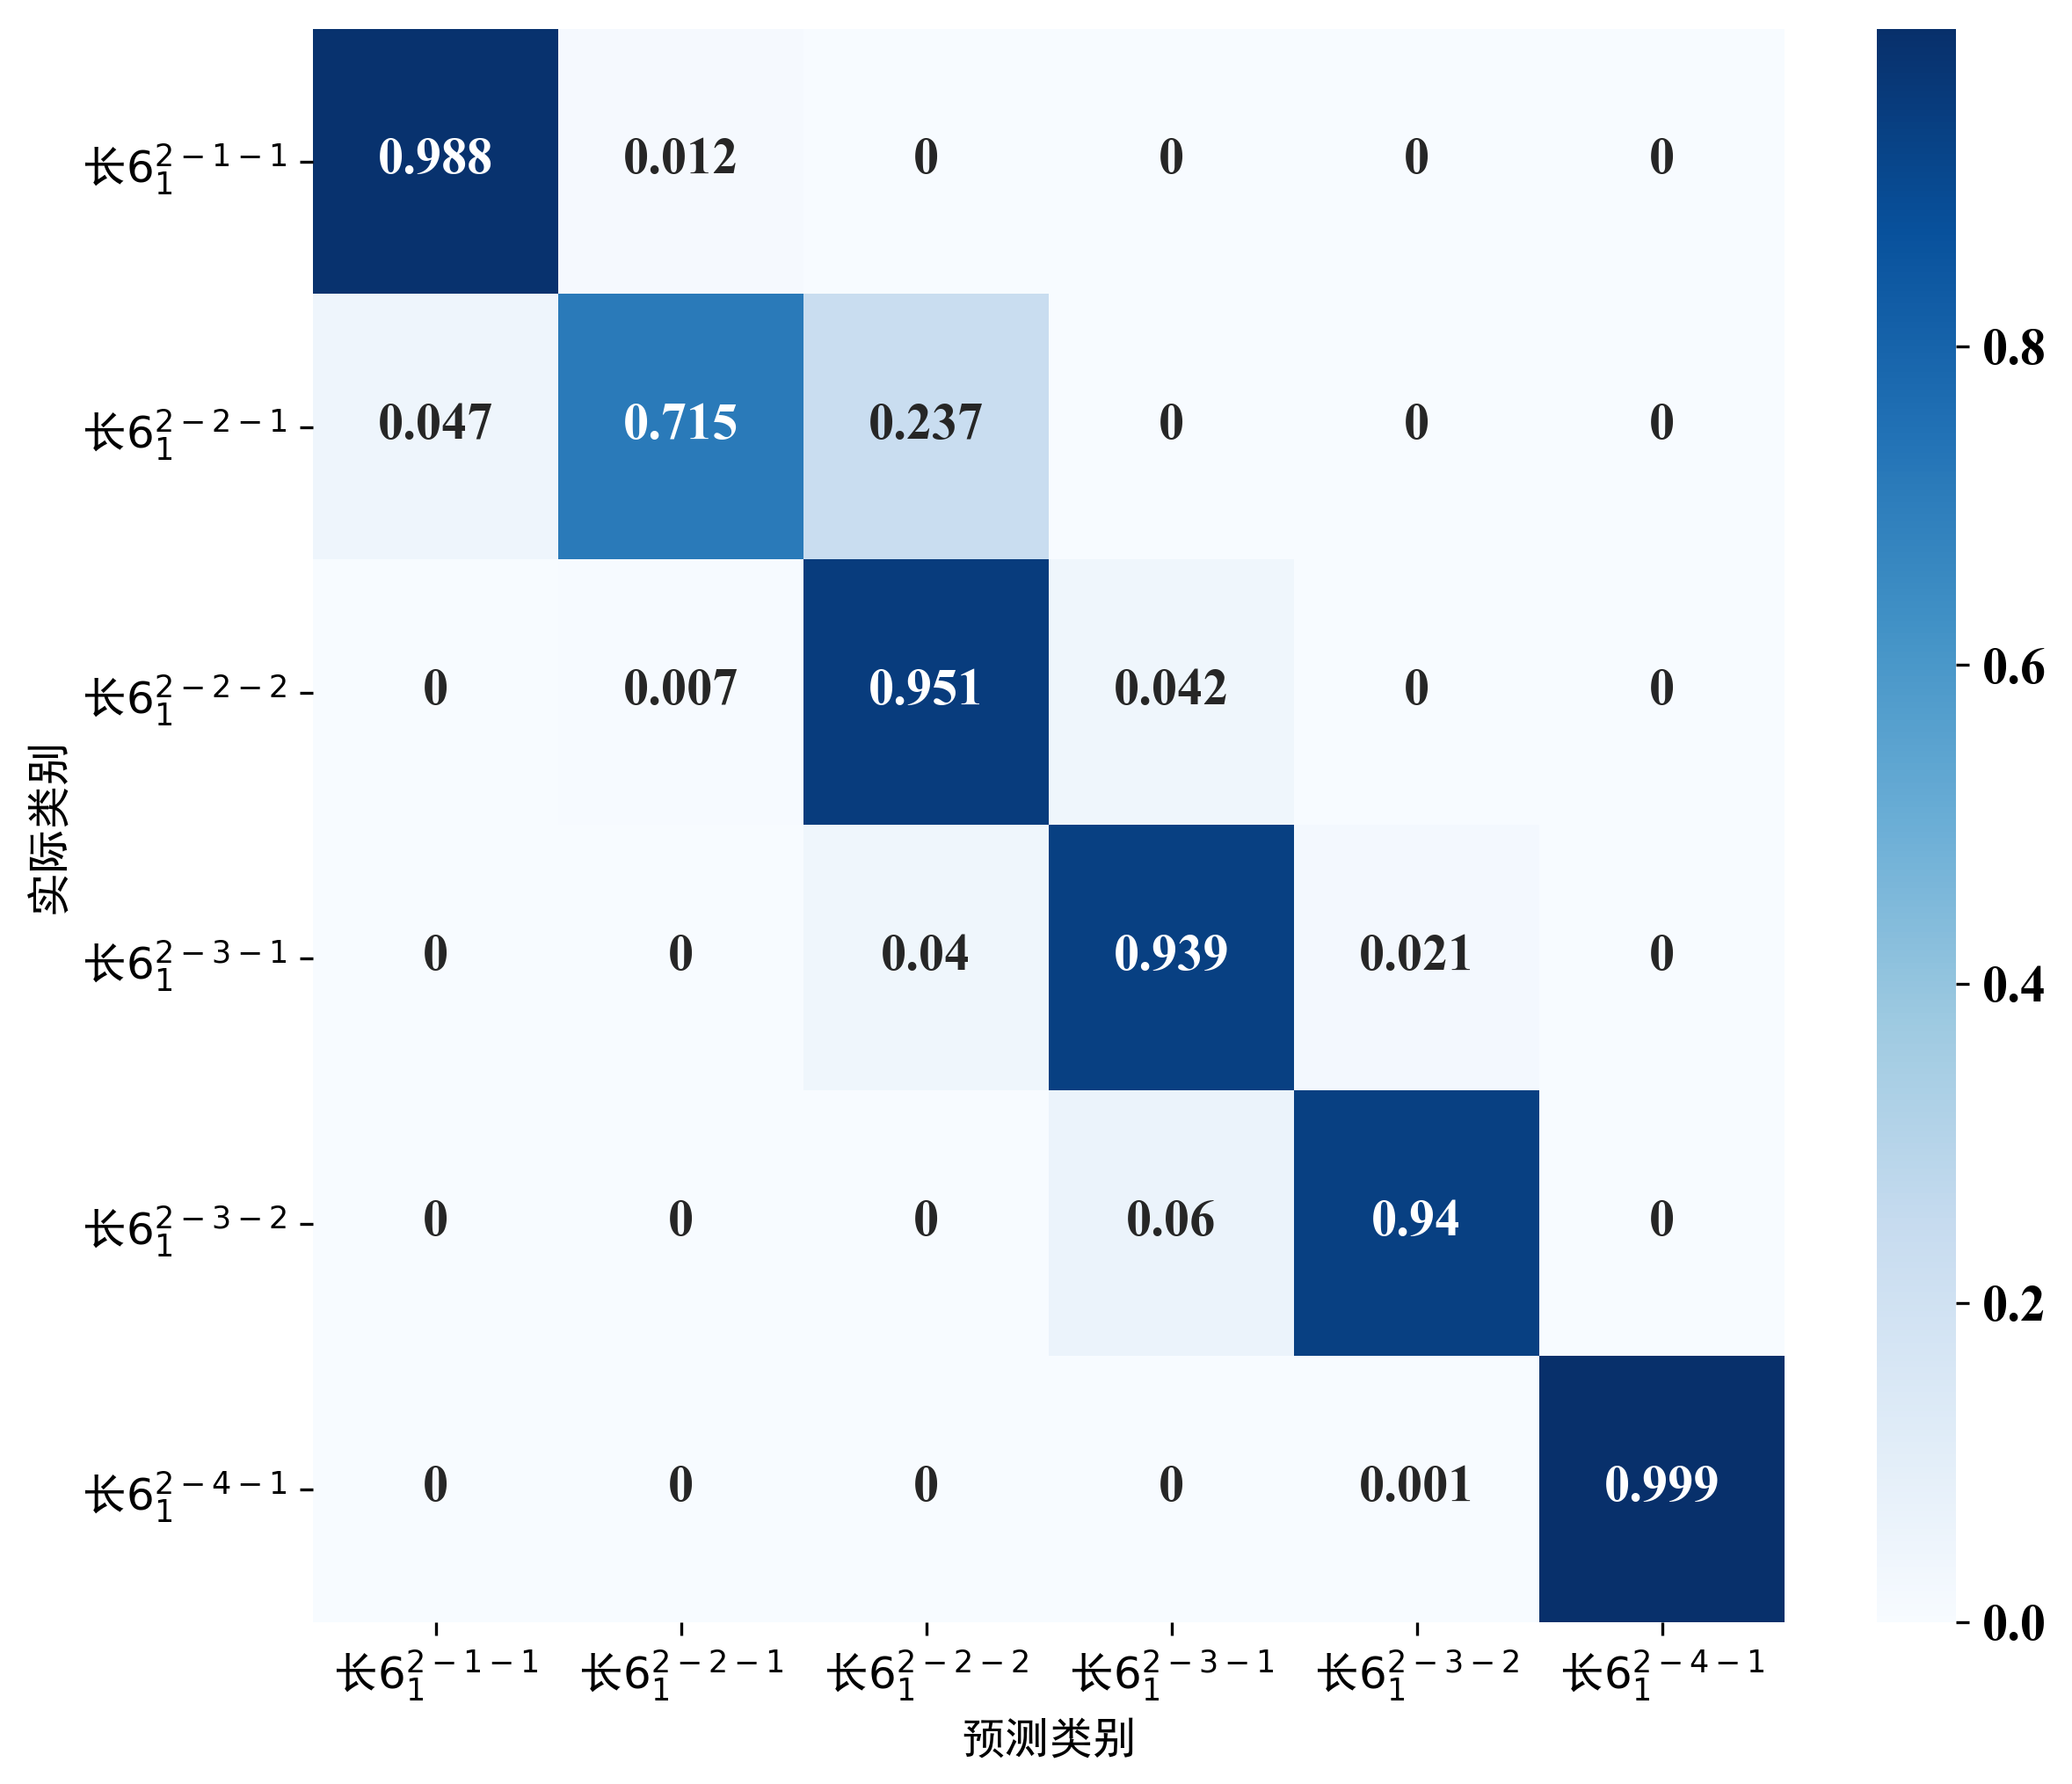

In [44]:
#中文字体黑体
font2 = {
    'family':'SimHei',
    #'weight':'bold',
#     'fontstyle':'italic',
    'size':15
}

#数字字体新罗马
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 15,
}
matplotlib.rc("font", **font)

#以cm6为例，展示混淆矩阵的形式
con_mat = cm6[1:7,1:7]
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis] # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=3)

# === plot ===
figure = plt.figure(figsize=(9, 8),dpi=300)
#以heatmap热力图的方式呈现混淆矩阵
ax = sns.heatmap(con_mat_norm, annot=True,fmt='.3g',cmap='Blues')
#设置横纵坐标对应的刻度显示
ax.set_xticklabels([r'长'+r'$6_1^{2-1-1}$',
                    r'长'+r'$6_1^{2-2-1}$',
                    r'长'+r'$6_1^{2-2-2}$',
                    r'长'+r'$6_1^{2-3-1}$',
                    r'长'+r'$6_1^{2-3-2}$',
                    r'长'+r'$6_1^{2-4-1}$',],font2)
ax.set_yticklabels([r'长'+r'$6_1^{2-1-1}$',
                    r'长'+r'$6_1^{2-2-1}$',
                    r'长'+r'$6_1^{2-2-2}$',
                    r'长'+r'$6_1^{2-3-1}$',
                    r'长'+r'$6_1^{2-3-2}$',
                    r'长'+r'$6_1^{2-4-1}$',],font2,rotation=360)

plt.ylim(6, 0)
plt.xlim(0, 6)
plt.xlabel('预测类别',font2)
plt.ylabel('实际类别',font2)
plt.savefig('./输出图片/混淆矩阵示例.jpg')

# 应用

## 应用前的准备函数

In [70]:
#粗略展示结果并输出识别结论到表格中
def draw_and_output(dataframe,a,b,c,d,e,f):
    #中文字体用黑体，西文字体新罗马
    font = {
        'family':'Times New Roman',
        #'weight':'bold',
        'size':13
    }
    font2 = {
        'family':'SimHei',
        #'weight':'bold',
        'size':13
    }
    
    dataframe['ACTUAL'] = a
    dataframe['CNN_1D']=b
    dataframe['LSTM'] = c
    dataframe['Bi-GRU'] = d
    dataframe['ABi-GRU'] = e
    dataframe['MC-ABiLSTM'] = f
    
    matplotlib.rc("font", **font)
    #这句是为了把刻度的方向朝内
    plt.rcParams['ytick.direction'] = 'in'
    cluster0 = np.repeat(np.expand_dims(dataframe['ACTUAL'],1), 100, 1)
    cluster1 = np.repeat(np.expand_dims(dataframe['CNN_1D'],1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(dataframe['LSTM'],1), 100, 1)
    cluster3 = np.repeat(np.expand_dims(dataframe['Bi-GRU'],1), 100, 1)
    cluster4 = np.repeat(np.expand_dims(dataframe['ABi-GRU'],1), 100, 1)
    cluster5 = np.repeat(np.expand_dims(dataframe['MC-ABiLSTM'],1), 100, 1)
    
    layers_colors = [
                     'red',#1  ---单砂体
                     'orange',#2  ---单砂体
                     'YELLOW',#3  ---单砂体
                     'lime',#4  ---单砂体
                     'cyan',#5  ---单砂体
                     'deepskyblue',#6  ---单砂体
                     'white',#7 ---隔夹层
                                         ]                             
    cmap_facies = colors.ListedColormap(
                layers_colors[0:len(layers_colors)], 'indexed')
    
    #画岩性柱的颜色
    layers_colors_cols = ['deepskyblue',#6 ---隔夹层
                         'cyan',#5  ---单砂体
                         'lime',#4  ---单砂体
                         'YELLOW',#3  ---单砂体
                         'orange',#2  ---单砂体
                         'RED',#1  ---单砂体
                         'white',#7  ---单砂体
                                         ]                             
    cmap_facies_cols = colors.ListedColormap(
                layers_colors_cols[0:len(layers_colors_cols)], 'indexed')

    ztop=dataframe.DEPTH.min(); zbot=dataframe.DEPTH.max()
    # 创建画布
    f, ax = plt.subplots(nrows=1, ncols=15, figsize=(16, 12), dpi = 300)
    #fig = plt.figure(figsize = (16,12), dpi = dpi)
    #ax1 = plt.subplot(1,13,1)
    ax[0].plot(dataframe.GR, dataframe.DEPTH, color='deepskyblue')
    ax[0].set_xlabel("GR(API)")
    ax[0].grid(linestyle='-.')
    ax[0].set_ylim(ztop,zbot)
    ax[0].invert_yaxis()
    ax[0].set_ylabel('深度(m)',font2)
    ax[0].set_xlim(dataframe.GR.min()-5,dataframe.GR.max()+2)
    
    ax[1].plot(dataframe.SP, dataframe.DEPTH,'-r')
    ax[1].set_xlim(dataframe.SP.min()-0.5,dataframe.SP.max()+2)
    ax[1].set_xlabel("SP(mV)")
    
    ax[2].plot(dataframe.RT, dataframe.DEPTH,'lime')
    ax[2].set_xlabel("RT(Ω·m)")
    
    ax[3].plot(dataframe.AC, dataframe.DEPTH,color='violet')
    ax[3].set_xlabel("AC(μs/m)")
    
    ax[4].plot(dataframe.POR, dataframe.DEPTH,color='deepskyblue',linestyle='--')
    ax[4].set_xlim(0,dataframe.POR.max()+5)
    ax[4].set_xlabel("POR(%)")
    
    ax[5].plot(dataframe.PERM, dataframe.DEPTH,color='red',linestyle='--')
    ax[5].set_xlabel("PERM(mD)")
    ax[5].set_xlim(0,dataframe.PERM.max()+3)
    
    ax[6].plot(dataframe.SW, dataframe.DEPTH,color='lime',linestyle='--')
    ax[6].set_xlabel("SW(%)")
    ax[6].set_xlim(dataframe.SW.min()-20,100)
    
    ax[7].plot(dataframe.CJWX, dataframe.DEPTH,color='k',linestyle='--')
    ax[7].set_xlabel("沉积微相",font2)
    ax[7].set_xlim(-0.5,3.5)
    ax[7].set_xticks([])
    
    ax[8].imshow(cluster1,interpolation='none', aspect='auto',
                          cmap=cmap_facies)
    ax[8].set_xlabel('1D-CNN',rotation=25)
    
    ax[9].imshow(cluster2,interpolation='none', aspect='auto',
                          cmap=cmap_facies)
    ax[9].set_xlabel('LSTM',rotation=25)
    
    ax[10].imshow(cluster3,interpolation='none', aspect='auto',
                          cmap=cmap_facies)
    ax[10].set_xlabel('Bi-GRU',rotation=25)
    
    ax[11].imshow(cluster4,interpolation='none', aspect='auto',
                          cmap=cmap_facies)
    ax[11].set_xlabel('ABi-GRU',rotation=25)
    
    ax[12].imshow(cluster5,interpolation='none', aspect='auto',
                          cmap=cmap_facies)
    ax[12].set_xlabel('MC-ABiLSTM',rotation=25)
    
    im1 = ax[13].imshow(cluster0,interpolation='none', aspect='auto',
                          cmap=cmap_facies_cols)
    im2 = ax[13].imshow(cluster0,interpolation='none', aspect='auto',
                          cmap=cmap_facies)
    #论文中删掉了专家识别结论的说法，转而直接在岩心上标记
    ax[13].set_xlabel('专家识别结论',font2,rotation=25)
    
    ax[14].plot(0,0,color='violet')
    
    ax[14].set_xlabel('岩心剖面',font2,rotation=25)
    divider = make_axes_locatable(ax[14])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im1, cax=cax)
    cbar.set_label((5*' ').join(['长'+r'$6_1^{2-4-1}$','长'+r'$6_1^{2-3-2}$', 
                                 '长'+r'$6_1^{2-3-1}$','长'+r'$6_1^{2-2-2}$',
                                   '长'+r'$6_1^{2-2-1}$','长'+r'$6_1^{2-1-1}$', 
                                          '隔夹层']),fontdict=font2)
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    #对前几列来说，统一网格线，顶底坐标
    for i in range(1,8):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid(linestyle='-.')
        yticks = ax[i].yaxis.get_major_ticks()
        for j in range(len(yticks)):
            yticks[j].label1.set_visible(False)
    
    for i in range(8,15):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
#     plt.show()
    plt.savefig('./输出图片/单井单砂体示例.jpg') 
    
    return dataframe

#统计元素数字总数，用来表示各层的层厚
def countX(dst, x):
    count = 0
    for point in dst:
        if (point == x):
            count = count + 1
    return count

## 应用于单井LJ38-365

In [64]:
app_well = padding_data.loc['罗检38-365',:]
app_well_input = app_well[CURVE]
app_not_padding = app_well[app_well['SSB']!=0]
origin = app_not_padding.SSB
length = app_not_padding.shape[0]
#增加一维batch_size
expand_1d_curves = np.expand_dims(app_well_input,axis=0)

#5种深度学习算法
pre1 = model1.predict(expand_1d_curves).argmax(-1)[0][:length]
pre2 = model2.predict(expand_1d_curves).argmax(-1)[0][:length]
pre3 = model3.predict(expand_1d_curves).argmax(-1)[0][:length]
pre4 = model4.predict(expand_1d_curves).argmax(-1)[0][:length]
pre5 = model5.predict(expand_1d_curves).argmax(-1)[0][:length]

#中值滤波，用来剔除一些极细的错误
pre1_f = medfilt(pre1,kernel_size=5)
pre2_f = medfilt(pre2,kernel_size=5)
pre3_f = medfilt(pre3,kernel_size=5)
pre4_f = medfilt(pre4,kernel_size=5)
pre5_f = medfilt(pre5,kernel_size=5)

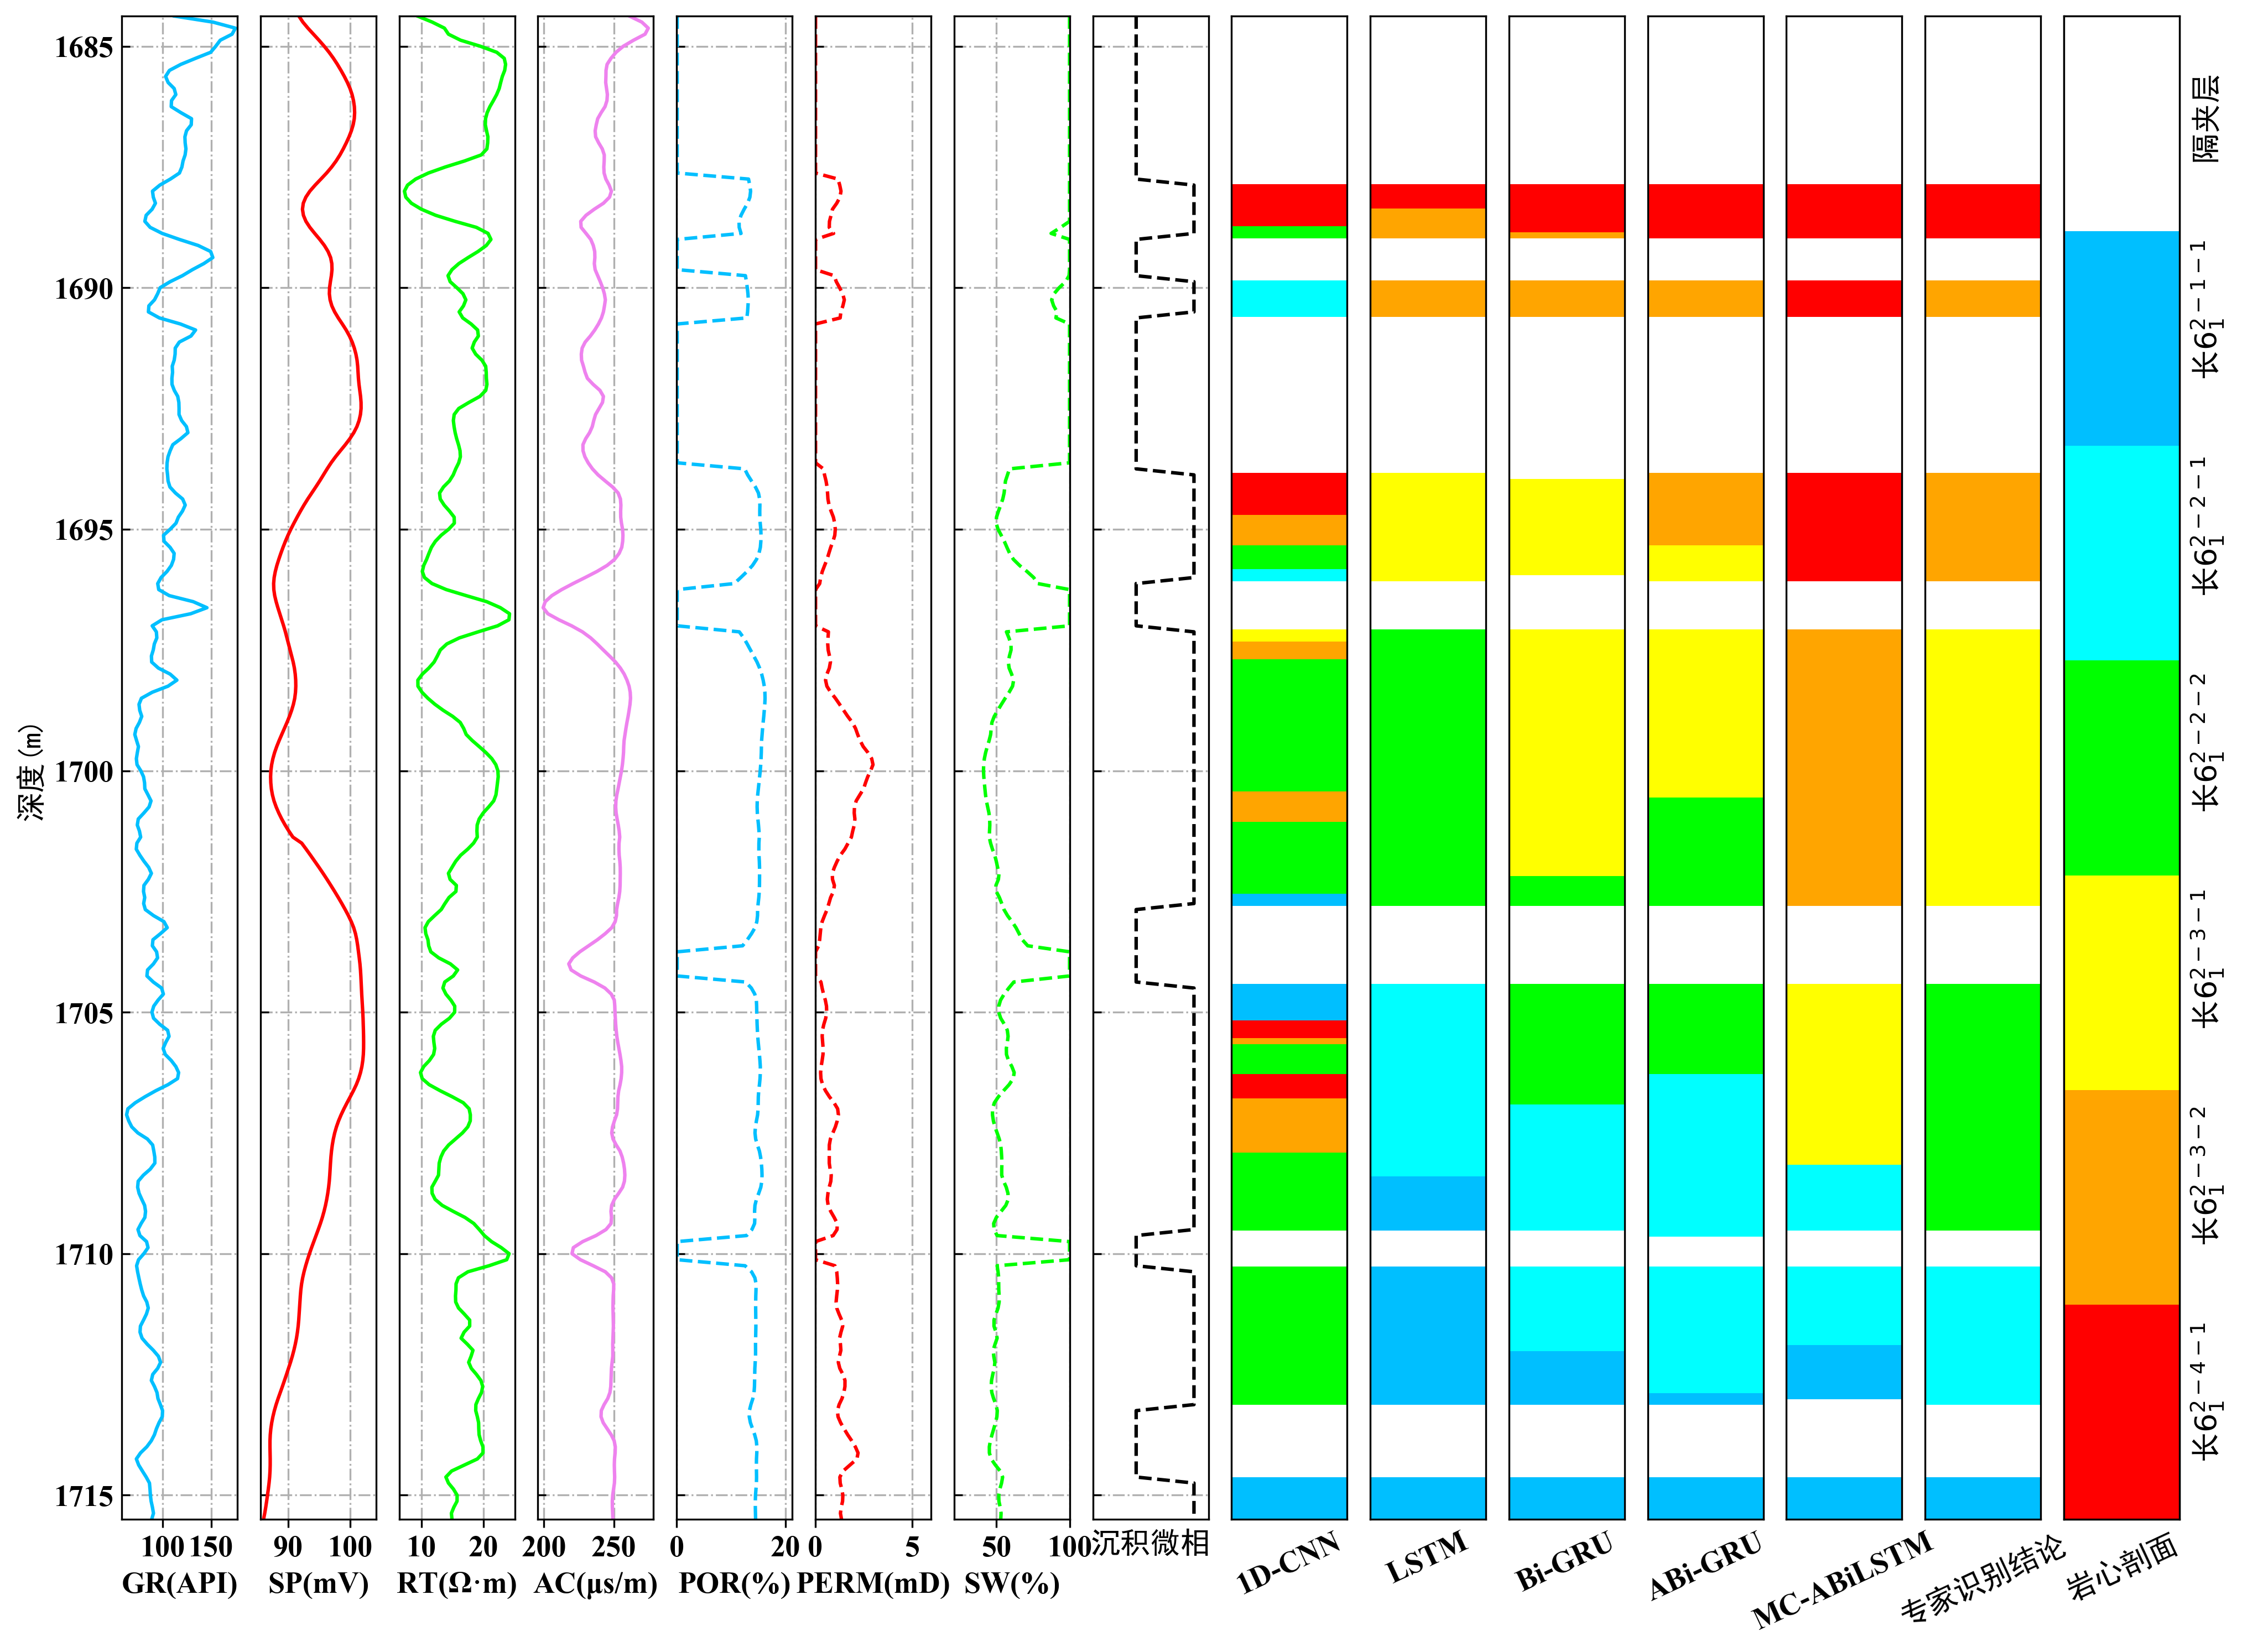

In [67]:
df = draw_and_output(app_not_padding,origin,pre1_f,pre2_f,pre3_f,pre4_f,pre5_f)

In [104]:
df.to_csv('./整合后csv/LJ36-385原始.csv',encoding='utf-8-sig')

### 微调

对识别结果进行中值滤波，平滑，微调

In [105]:
df_modify = pd.read_csv('./整合后csv/LJ36-385微调.csv',encoding='utf-8')

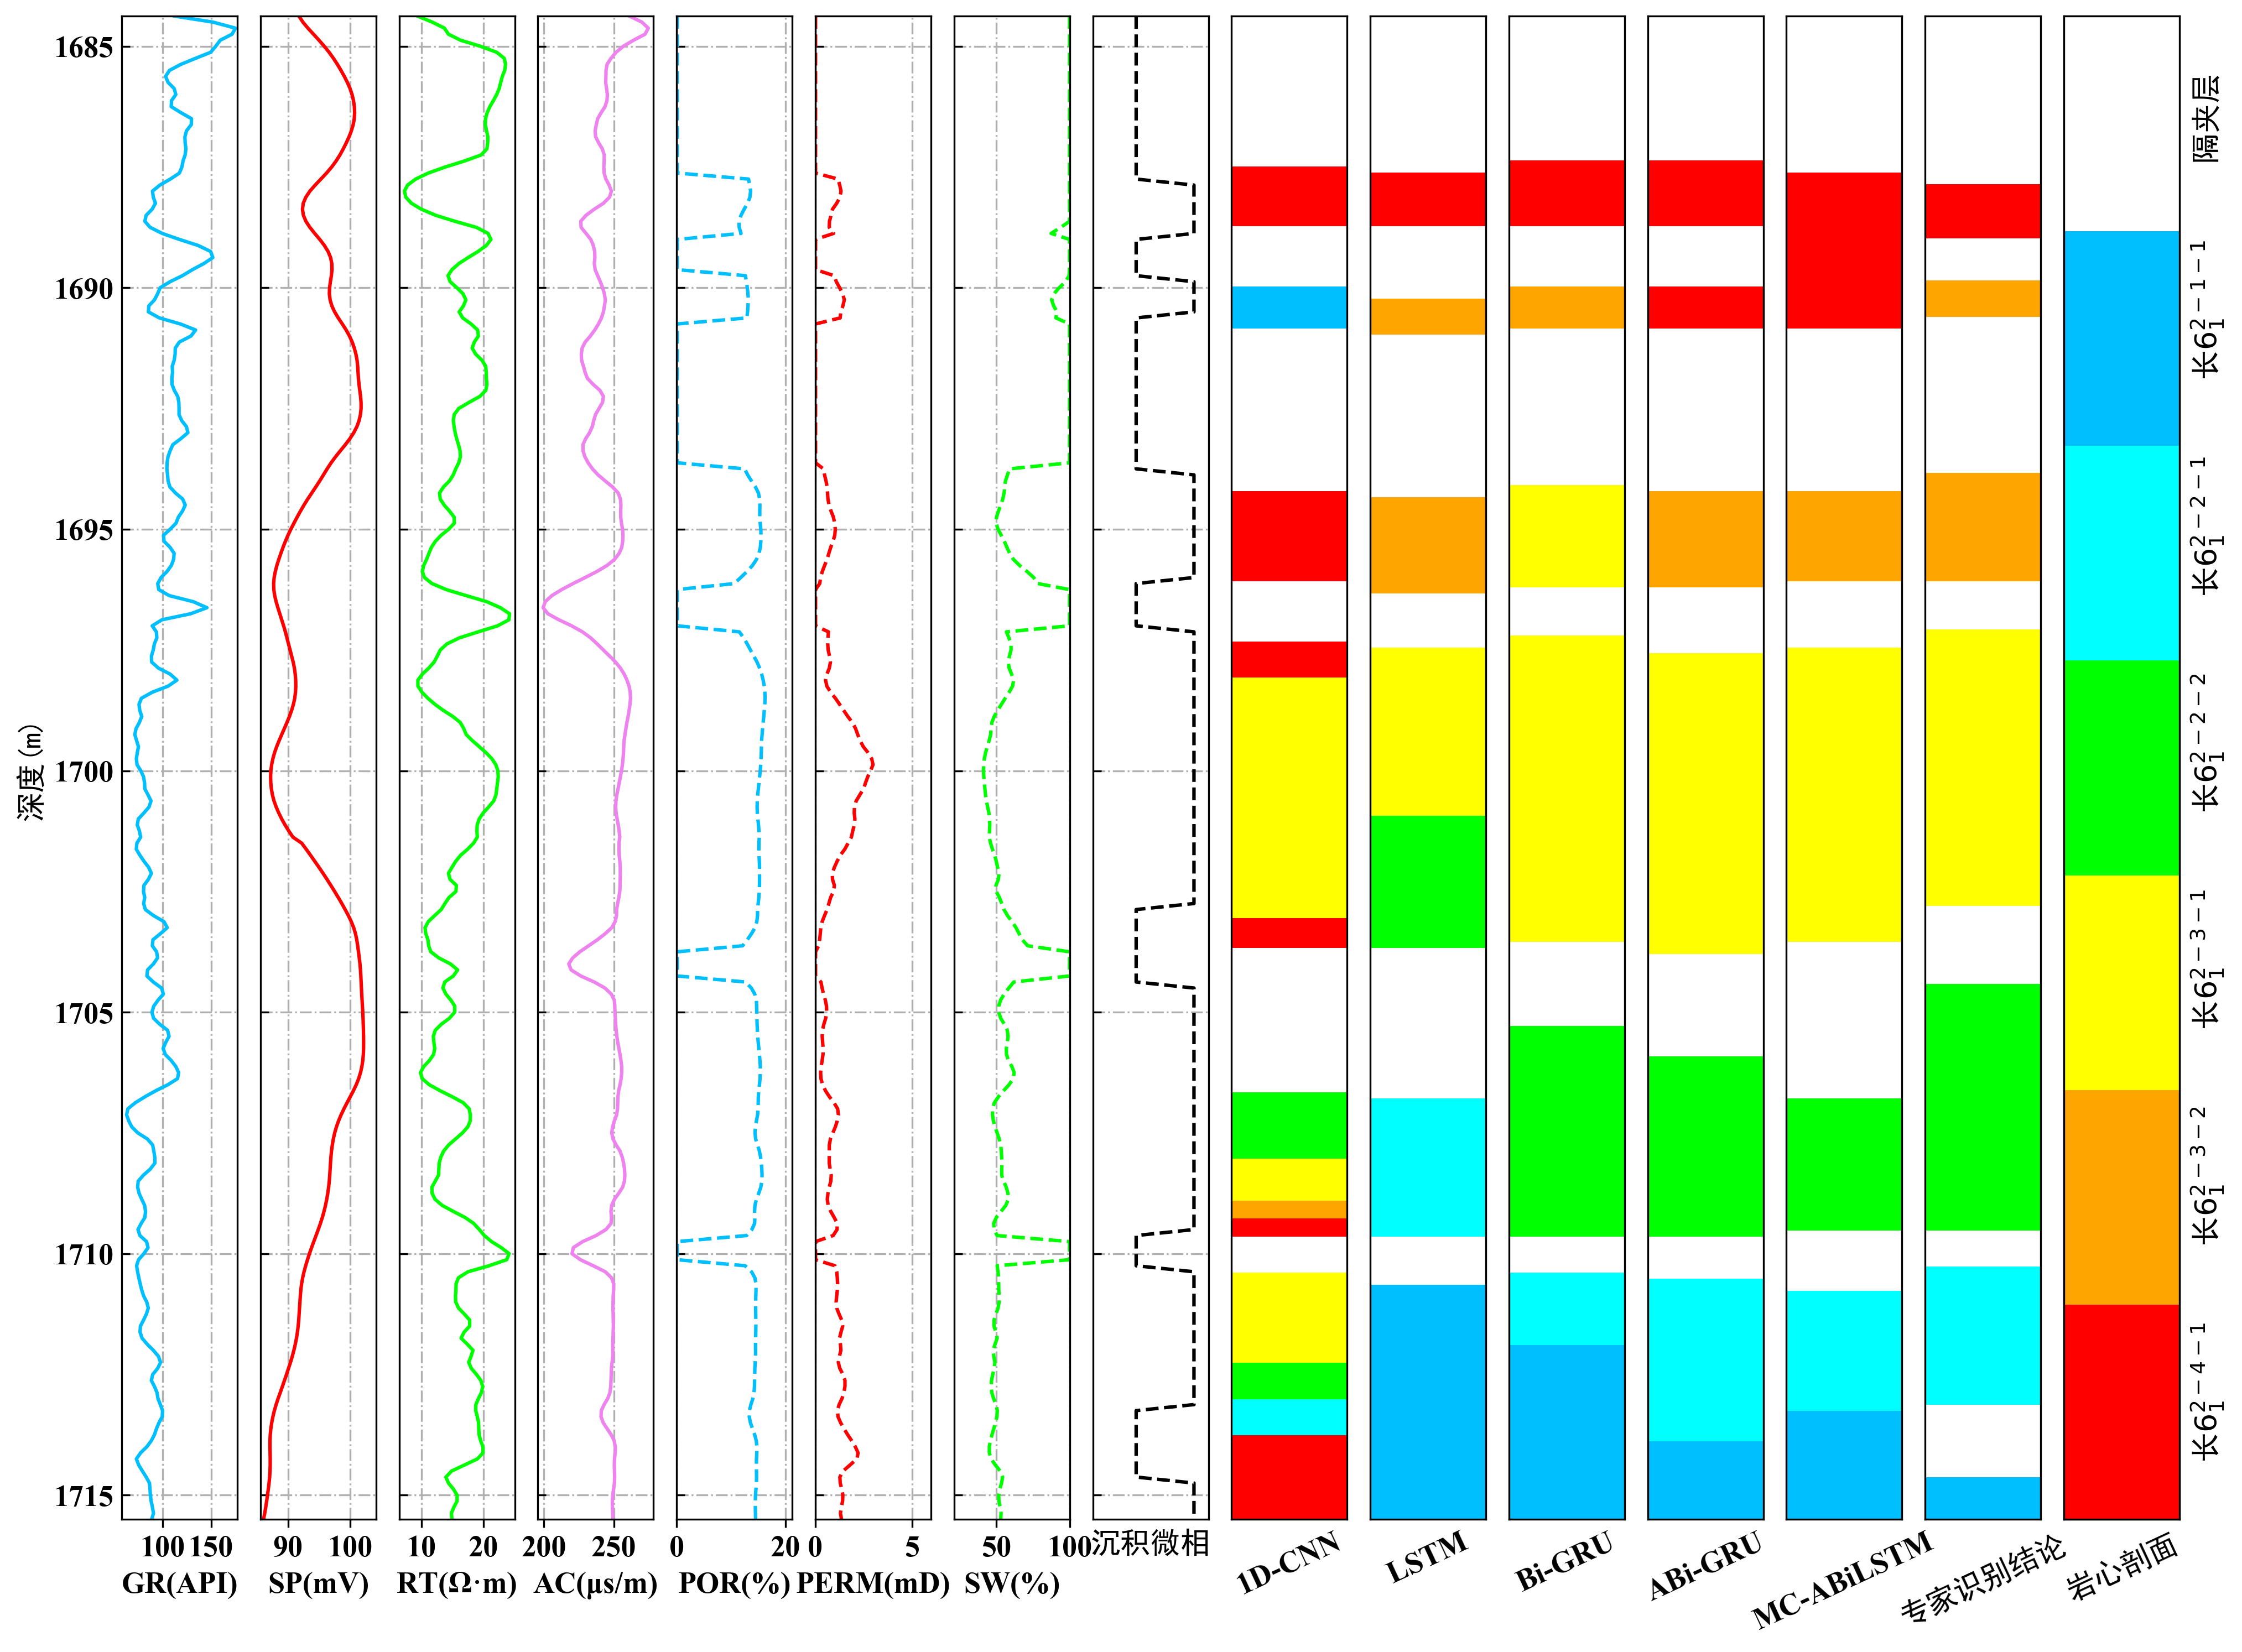

,DEPTH,GR,SP,RT,AC,POR,PERM,SW,SSB,CJWX,...,POR_sign,PERM_sign,SW_sign,DEPTH_sign,ACTUAL,CNN_1D,LSTM,Bi-GRU,ABi-GRU,MC-ABiLSTM
WELL_ID,,,,,,,,,,,,,,,,,,,,,
罗检38-365,1684.375,112.301,91.749,9.391,261.168,0.100,0.010,99.900,7.0,1.0,...,0.0,0.0,0.0,0.0,7,7,7,7,7,7
罗检38-365,1684.500,151.915,92.388,11.756,270.068,0.100,0.010,99.900,7.0,1.0,...,0.0,0.0,0.0,1.0,7,7,7,7,7,7
罗检38-365,1684.625,174.993,93.199,13.725,274.639,0.100,0.010,99.900,7.0,1.0,...,0.0,0.0,0.0,1.0,7,7,7,7,7,7
罗检38-365,1684.750,171.593,94.088,14.376,272.365,0.100,0.010,99.900,7.0,1.0,...,0.0,0.0,0.0,1.0,7,7,7,7,7,7
罗检38-365,1684.875,159.425,94.980,16.338,264.125,0.100,0.010,99.900,7.0,1.0,...,0.0,0.0,0.0,1.0,7,7,7,7,7,7
罗检38-365,1685.000,154.769,95.824,19.535,256.801,0.100,0.010,99.900,7.0,1.0,...,0.0,0.0,0.0,1.0,7,7,7,7,7,7
罗检38-365,1685.125,149.573,96.604,22.175,251.629,0.100,0.010,99.900,7.0,1.0,...,0.0,0.0,0.0,1.0,7,7,7,7,7,7
罗检38-365,1685.250,134.007,97.305,23.388,248.006,0.100,0.010,99.900,7.0,1.0,...,0.0,0.0,0.0,1.0,7,7,7,7,7,7
罗检38-365,1685.375,118.923,97.940,23.608,245.220,0.100,0.010,99.900,7.0,1.0,...,0.0,0.0,0.0,1.0,7,7,7,7,7,7


In [111]:
#5种深度学习算法
origin = df_modify['SSB'].values
pre1 = df_modify['CNN_1D'].values
pre2 = df_modify['LSTM'].values
pre3 = df_modify['Bi-GRU'].values
pre4 = df_modify['ABi-GRU'].values
pre5 = df_modify['MC-ABiLSTM'].values
draw_and_output(app_not_padding,origin,pre1,pre2,pre3,pre4,pre5)

## 应用于多井，统计砂厚图

In [82]:
wellname = padding_data.index.unique().tolist()
WELL = []
for i in wellname:
    log = padding_data[padding_data.index==i].reset_index(drop=True)
    well_input = log[CURVE]
    expand_1d_curves = np.expand_dims(well_input,axis=0)
    #以model5为例
    pre = model5.predict(expand_1d_curves).argmax(-1)
    #中值滤波剔除一些杂乱无章的点
    answer = medfilt(pre[0],kernel_size=5)
    
    c1 = countX(answer.tolist(),1)
    c2 = countX(answer.tolist(),2)
    c3 = countX(answer.tolist(),3)
    c4 = countX(answer.tolist(),4)
    c5 = countX(answer.tolist(),5)
    c6 = countX(answer.tolist(),6)
    
    c1_length = c1*0.125
    c2_length = c2*0.125
    c3_length = c3*0.125
    c4_length = c4*0.125
    c5_length = c5*0.125
    c6_length = c6*0.125
    
    WELL.append([i,c1_length,c2_length,c3_length,c4_length,c5_length,c6_length])

In [83]:
WELL

[['DP10', 1.5, 4.375, 2.25, 4.5, 1.5, 1.5],
 ['DP3', 1.5, 3.25, 6.0, 2.125, 4.0, 4.125],
 ['ZJ47', 0.0, 1.375, 5.25, 2.25, 4.625, 0.0],
 ['ZJ65', 0.0, 3.375, 4.5, 3.625, 4.375, 0.0],
 ['天189', 1.125, 2.0, 1.875, 3.75, 1.5, 0.0],
 ['罗18-33', 1.375, 2.5, 3.5, 1.25, 1.125, 1.125],
 ['罗18-39', 0.0, 2.75, 2.625, 2.625, 1.0, 0.0],
 ['罗18-41', 1.25, 3.625, 3.0, 3.375, 1.25, 0.0],
 ['罗19-28', 0.875, 2.0, 3.625, 1.25, 1.875, 0.0],
 ['罗19-32', 1.125, 2.75, 3.5, 0.875, 0.0, 0.0],
 ['罗19-33', 1.5, 3.375, 4.125, 3.5, 0.875, 0.75],
 ['罗19-35', 1.375, 2.75, 1.5, 1.875, 1.625, 1.875],
 ['罗19-36', 1.75, 2.5, 1.75, 2.625, 1.25, 1.5],
 ['罗19-38', 1.25, 3.25, 3.875, 1.25, 0.75, 0.0],
 ['罗20-27', 1.25, 2.625, 2.375, 2.0, 1.5, 0.0],
 ['罗20-29', 1.25, 2.625, 2.375, 0.0, 2.125, 0.25],
 ['罗20-41', 0.0, 2.0, 2.25, 2.875, 1.375, 1.125],
 ['罗21-30', 1.5, 3.375, 2.625, 2.125, 1.375, 2.0],
 ['罗21-35', 1.875, 3.625, 4.25, 2.125, 0.0, 0.0],
 ['罗22-31', 0.0, 5.0, 2.875, 1.5, 1.25, 1.875],
 ['罗22-36', 2.0, 2.625, 3.125

In [84]:
pd.DataFrame(WELL).to_csv('./整合后csv/MC-ABiLSTM砂厚图.csv',encoding='utf-8-sig',index=None)